### setup

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import time
import yaml

from myyololib.dataset import get_dataloader, preprocess_dataset
from myyololib.models import MyYOLOv8n, QYOLOv8n, NYOLOv8n

from myyololib.train_config import TrainConfig, FinetuneConfig
from myyololib.trainer import train
from myyololib.evaluator import evaluate
from myyololib.load_model import load_model, load_QAT_model, load_NPU_model
from myyololib.visualize import visualize_multiple_tensors, visualize_float_tensor_distribution, \
    visualize_tensor_distribution, visualize_multiple_poz, ActivationStatsCollector
from myyololib.npu_blocks import NConv2d
from myyololib.basic_blocks import DFL
from myyololib.qat_blocks import QConv2d, QConv
from myyololib.demo import demo


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model

In [2]:
train_loader, val_loader, coco_id2label, label2coco_category = get_dataloader()

loading annotations into memory...
Done (t=31.24s)
creating index...
index created!
loading annotations into memory...
Done (t=5.39s)
creating index...
index created!


In [15]:
# model = load_model('checkpoints/yolov8n.pt', device)

In [4]:
model = load_model('checkpoints/yolov8n.pt', device)

Start matching keys...

Matching keys done.



In [3]:
model = load_model('checkpoints/relu_091214.pth', device)

Loaded .pth state_dict
Start matching keys...

Matching keys done.



In [4]:
# load QAT model with quantization config
with open('./config/qcfg_0928.yaml') as f:
    loaded_cfg = yaml.safe_load(f)

Qmodel = load_model('checkpoints/qat_09272248.pt', device, model_type="qat", model_qcfg=loaded_cfg)

Start matching keys...

Matching keys done.



# Train

In [ ]:
Qmodel = load_QAT_model('checkpoints/relu_091214.pth', device, model_qcfg=loaded_cfg)
# QAT model fine-tuning
train(Qmodel, train_loader, val_loader, device, FinetuneConfig)

# Visualize

## Weight

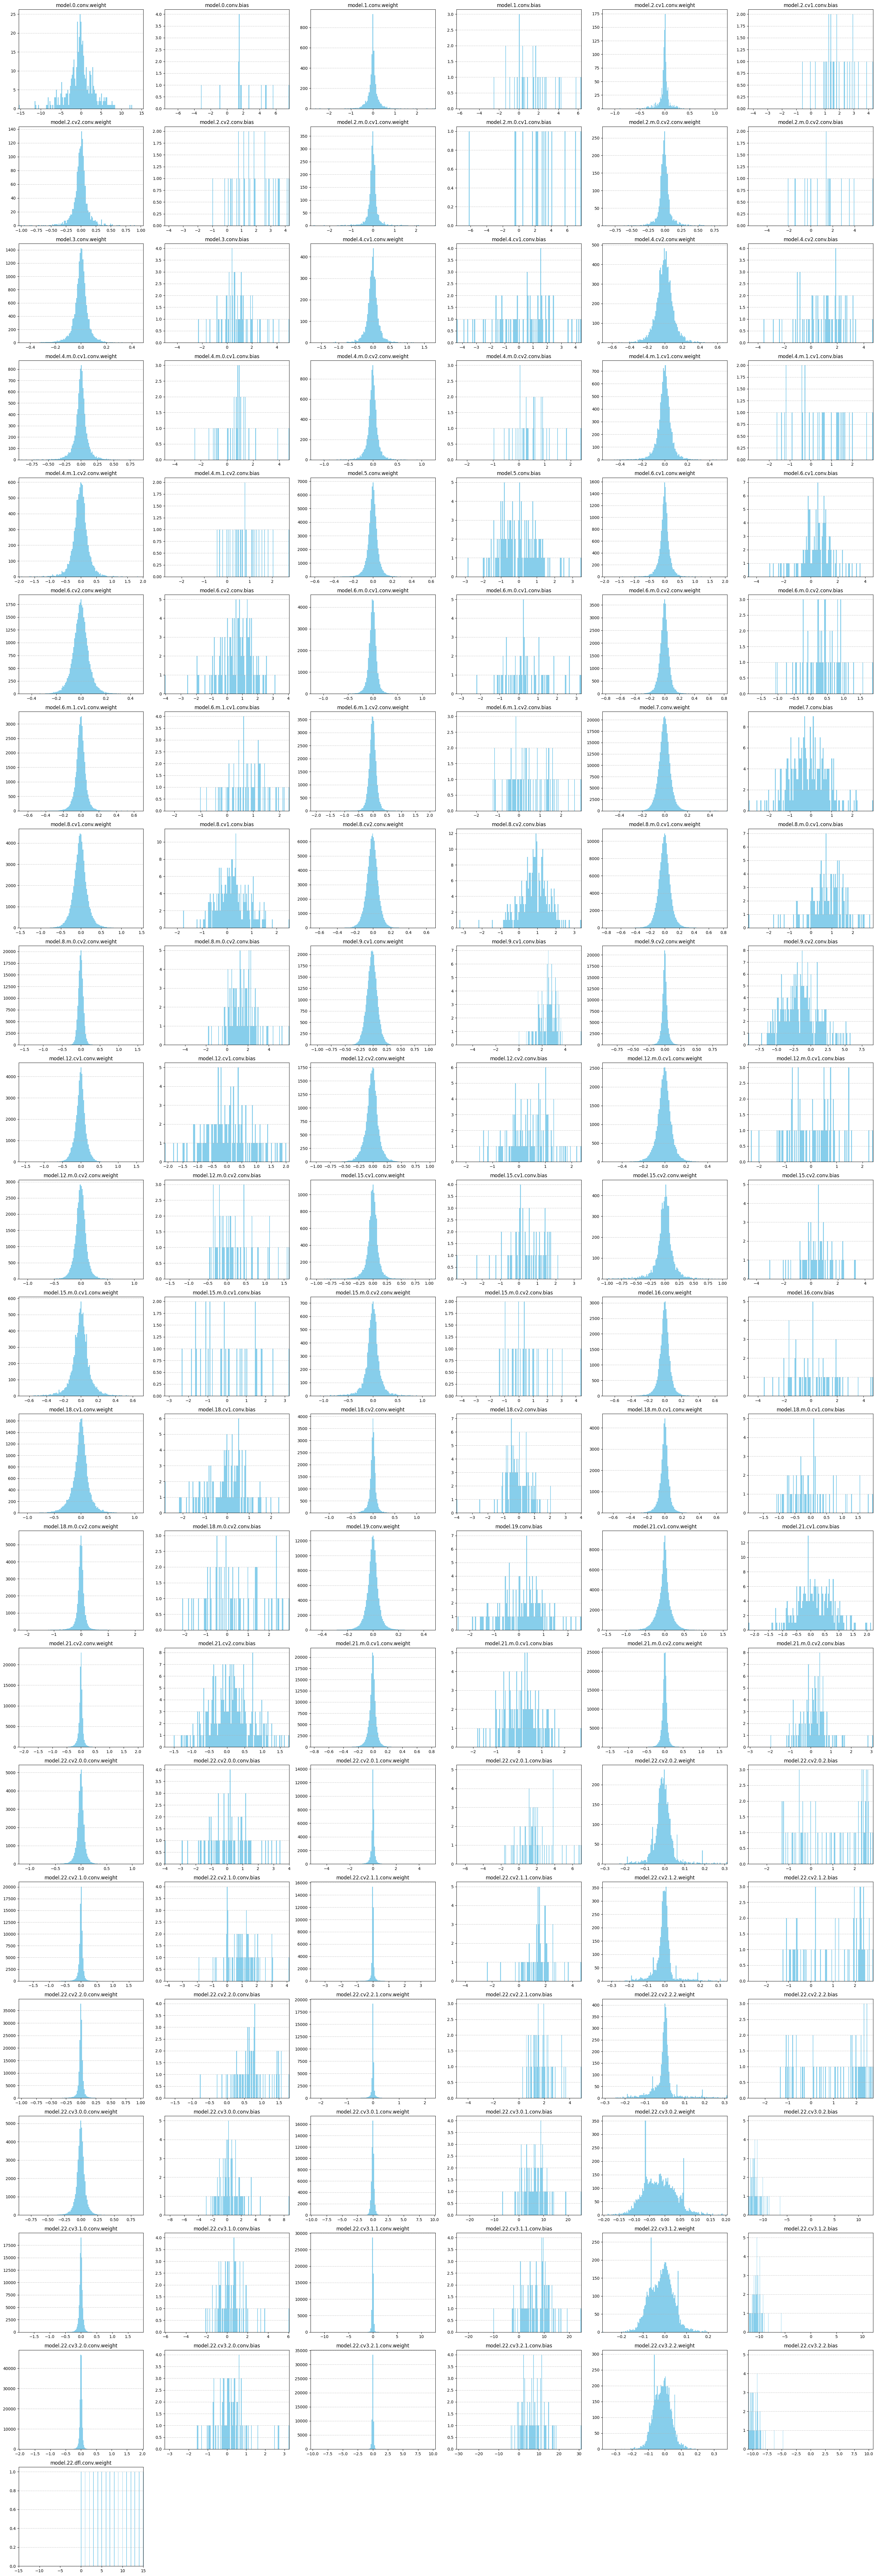

In [5]:
visualize_multiple_tensors(Qmodel.state_dict(), bins=128, n_cols=6)

## Activation

In [4]:
Nmodel = load_NPU_model('checkpoints/qat_091501.pth', device)

Loaded .pth state_dict
Start matching keys...

Matching keys done.



In [5]:
asc = ActivationStatsCollector(Nmodel, NConv2d)

In [6]:
# load trained NPU test_model and register hooks
run_batch = 1
for _ in range(run_batch): # run multiple iterations to collect activation statistics
    with torch.no_grad():
        images, annotations = next(iter(train_loader))
        inputs, batch = preprocess_dataset(images, annotations, coco_id2label, device) # preprocess dataset
        outputs = Nmodel(inputs, inference=True)
activation_stats = asc.get_stats()


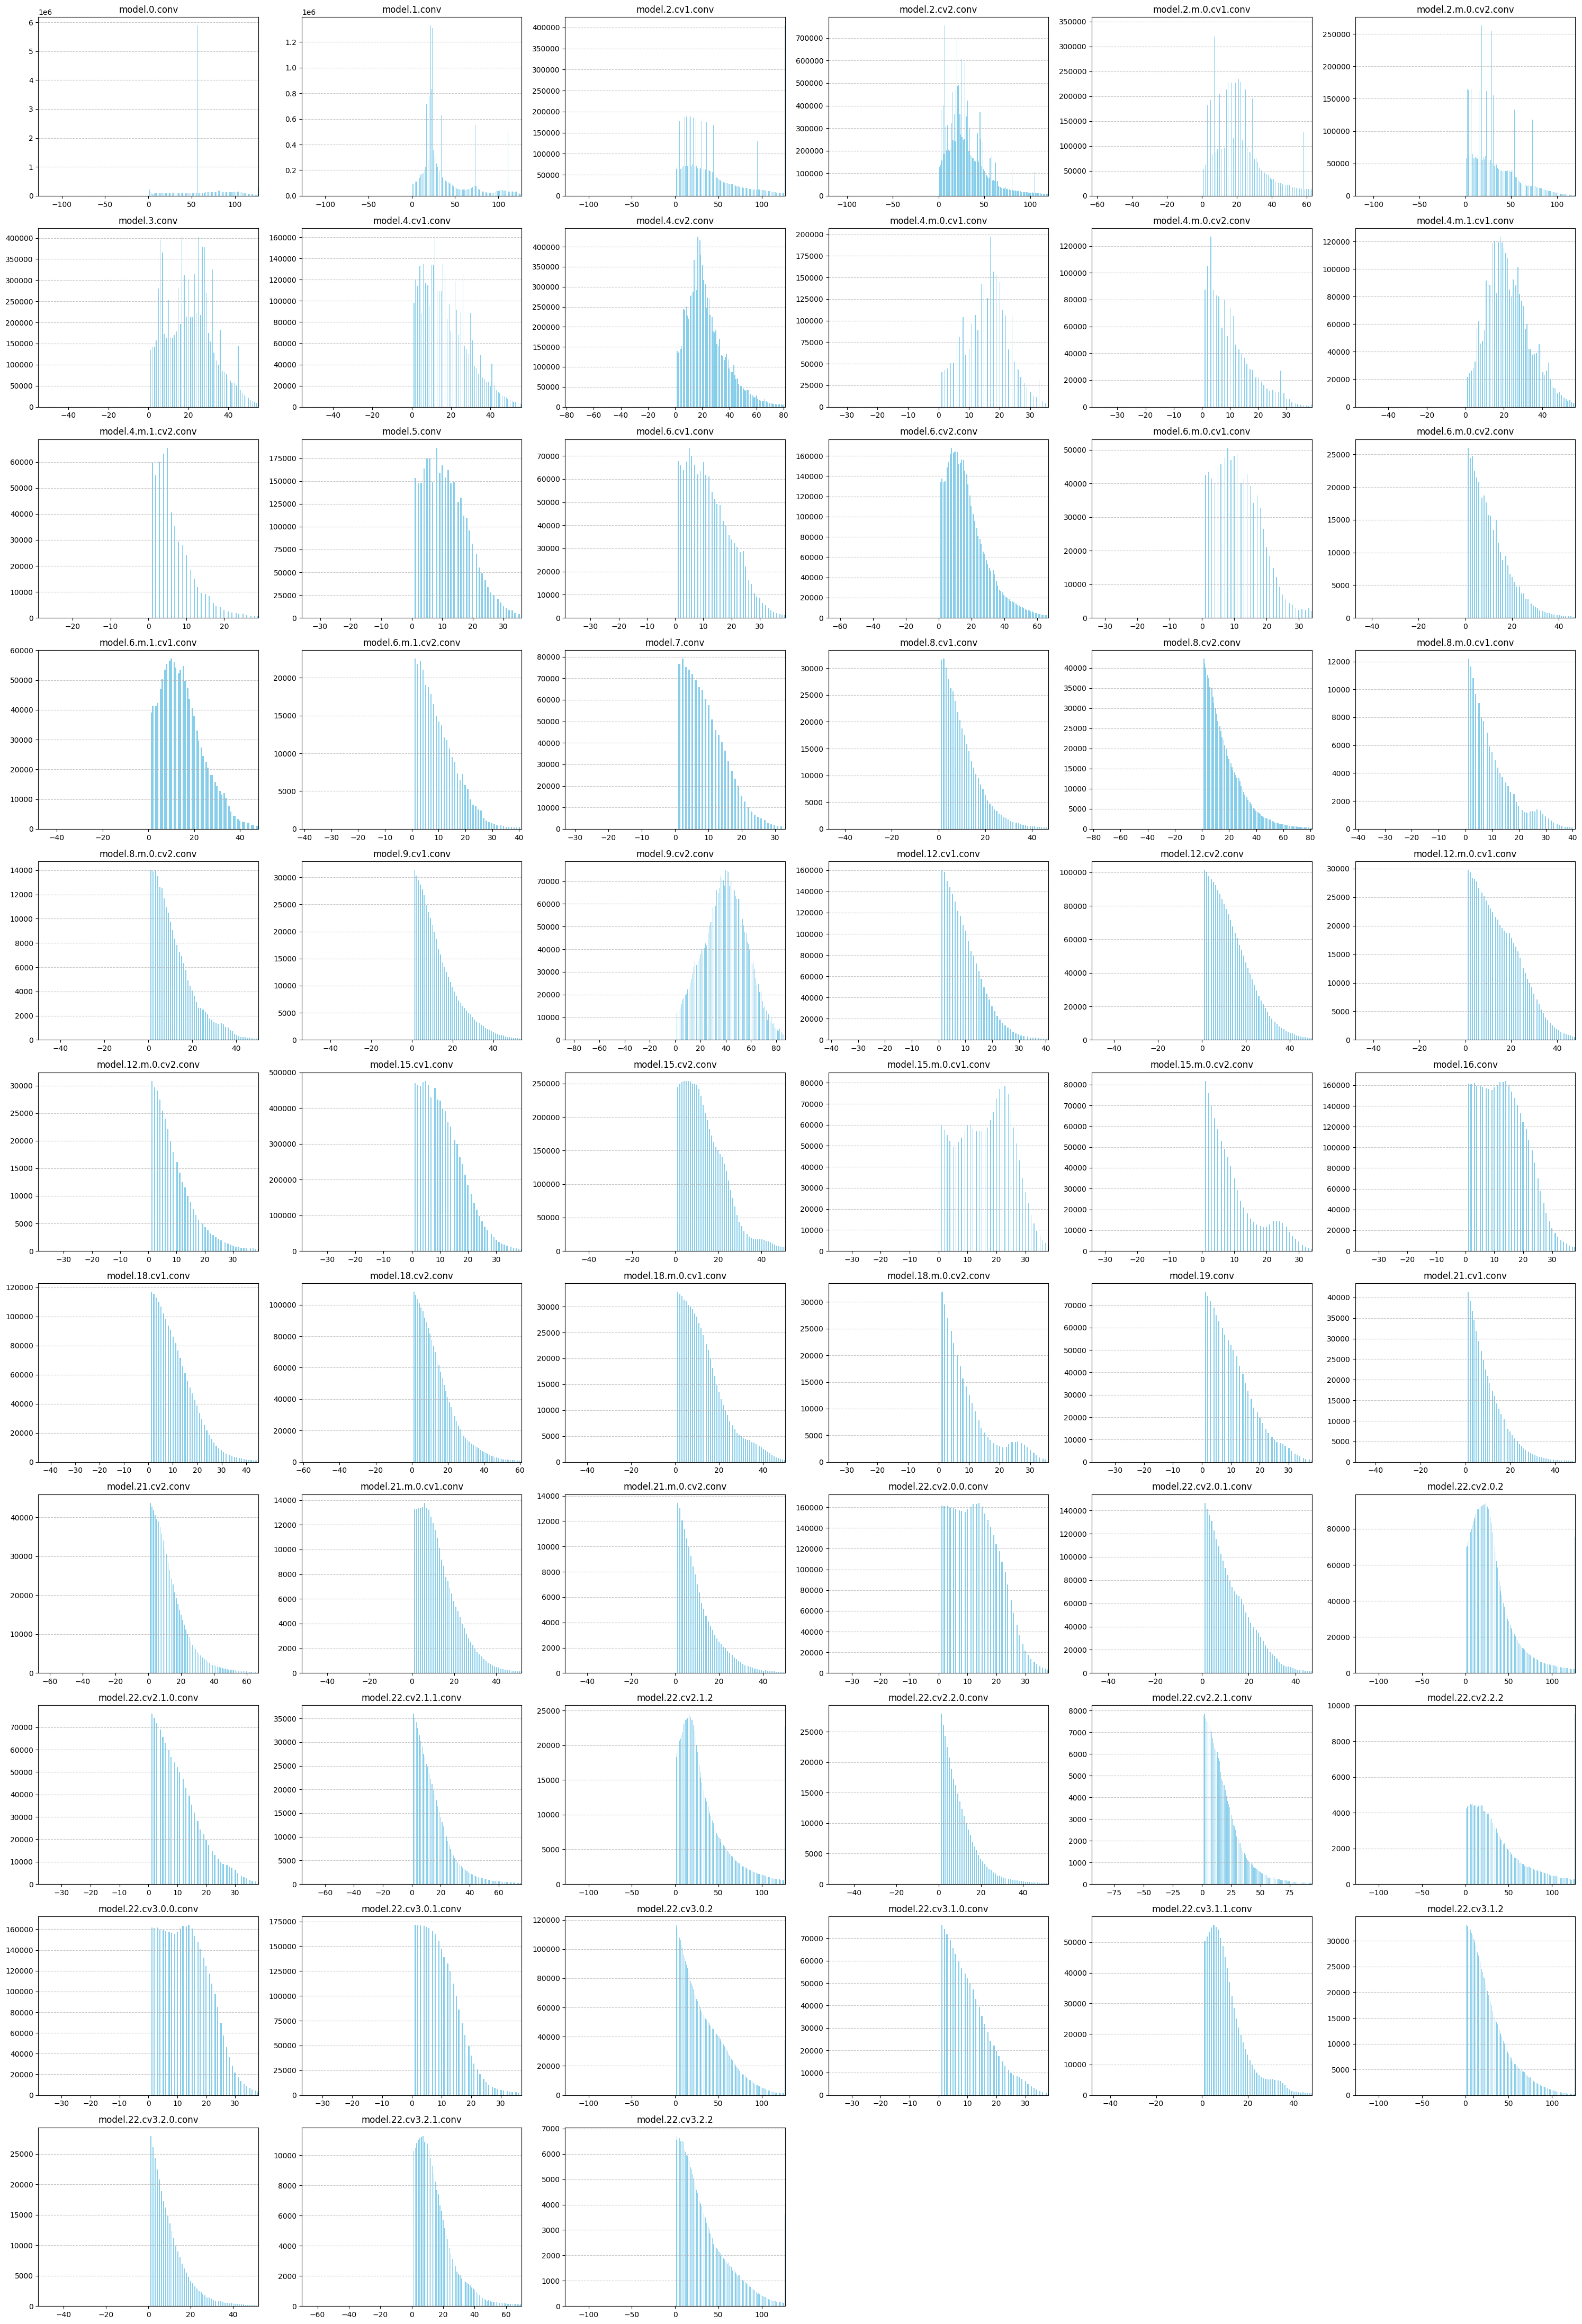

In [7]:
act_stats = {}
for layer_name, acts in activation_stats.items():
    acts = torch.cat(acts, dim=0)  # concatenate all batches
    temp = acts.permute(1, 0, 2, 3).contiguous()
    zero_mask = acts != 0 
    act_stats[layer_name] = acts[zero_mask] if zero_mask.sum() > 0 else torch.tensor(0.0)

visualize_multiple_tensors(act_stats, bins=256, n_cols=6) # zero values are excluded

## QAT Act

Start matching keys...

Matching keys done.



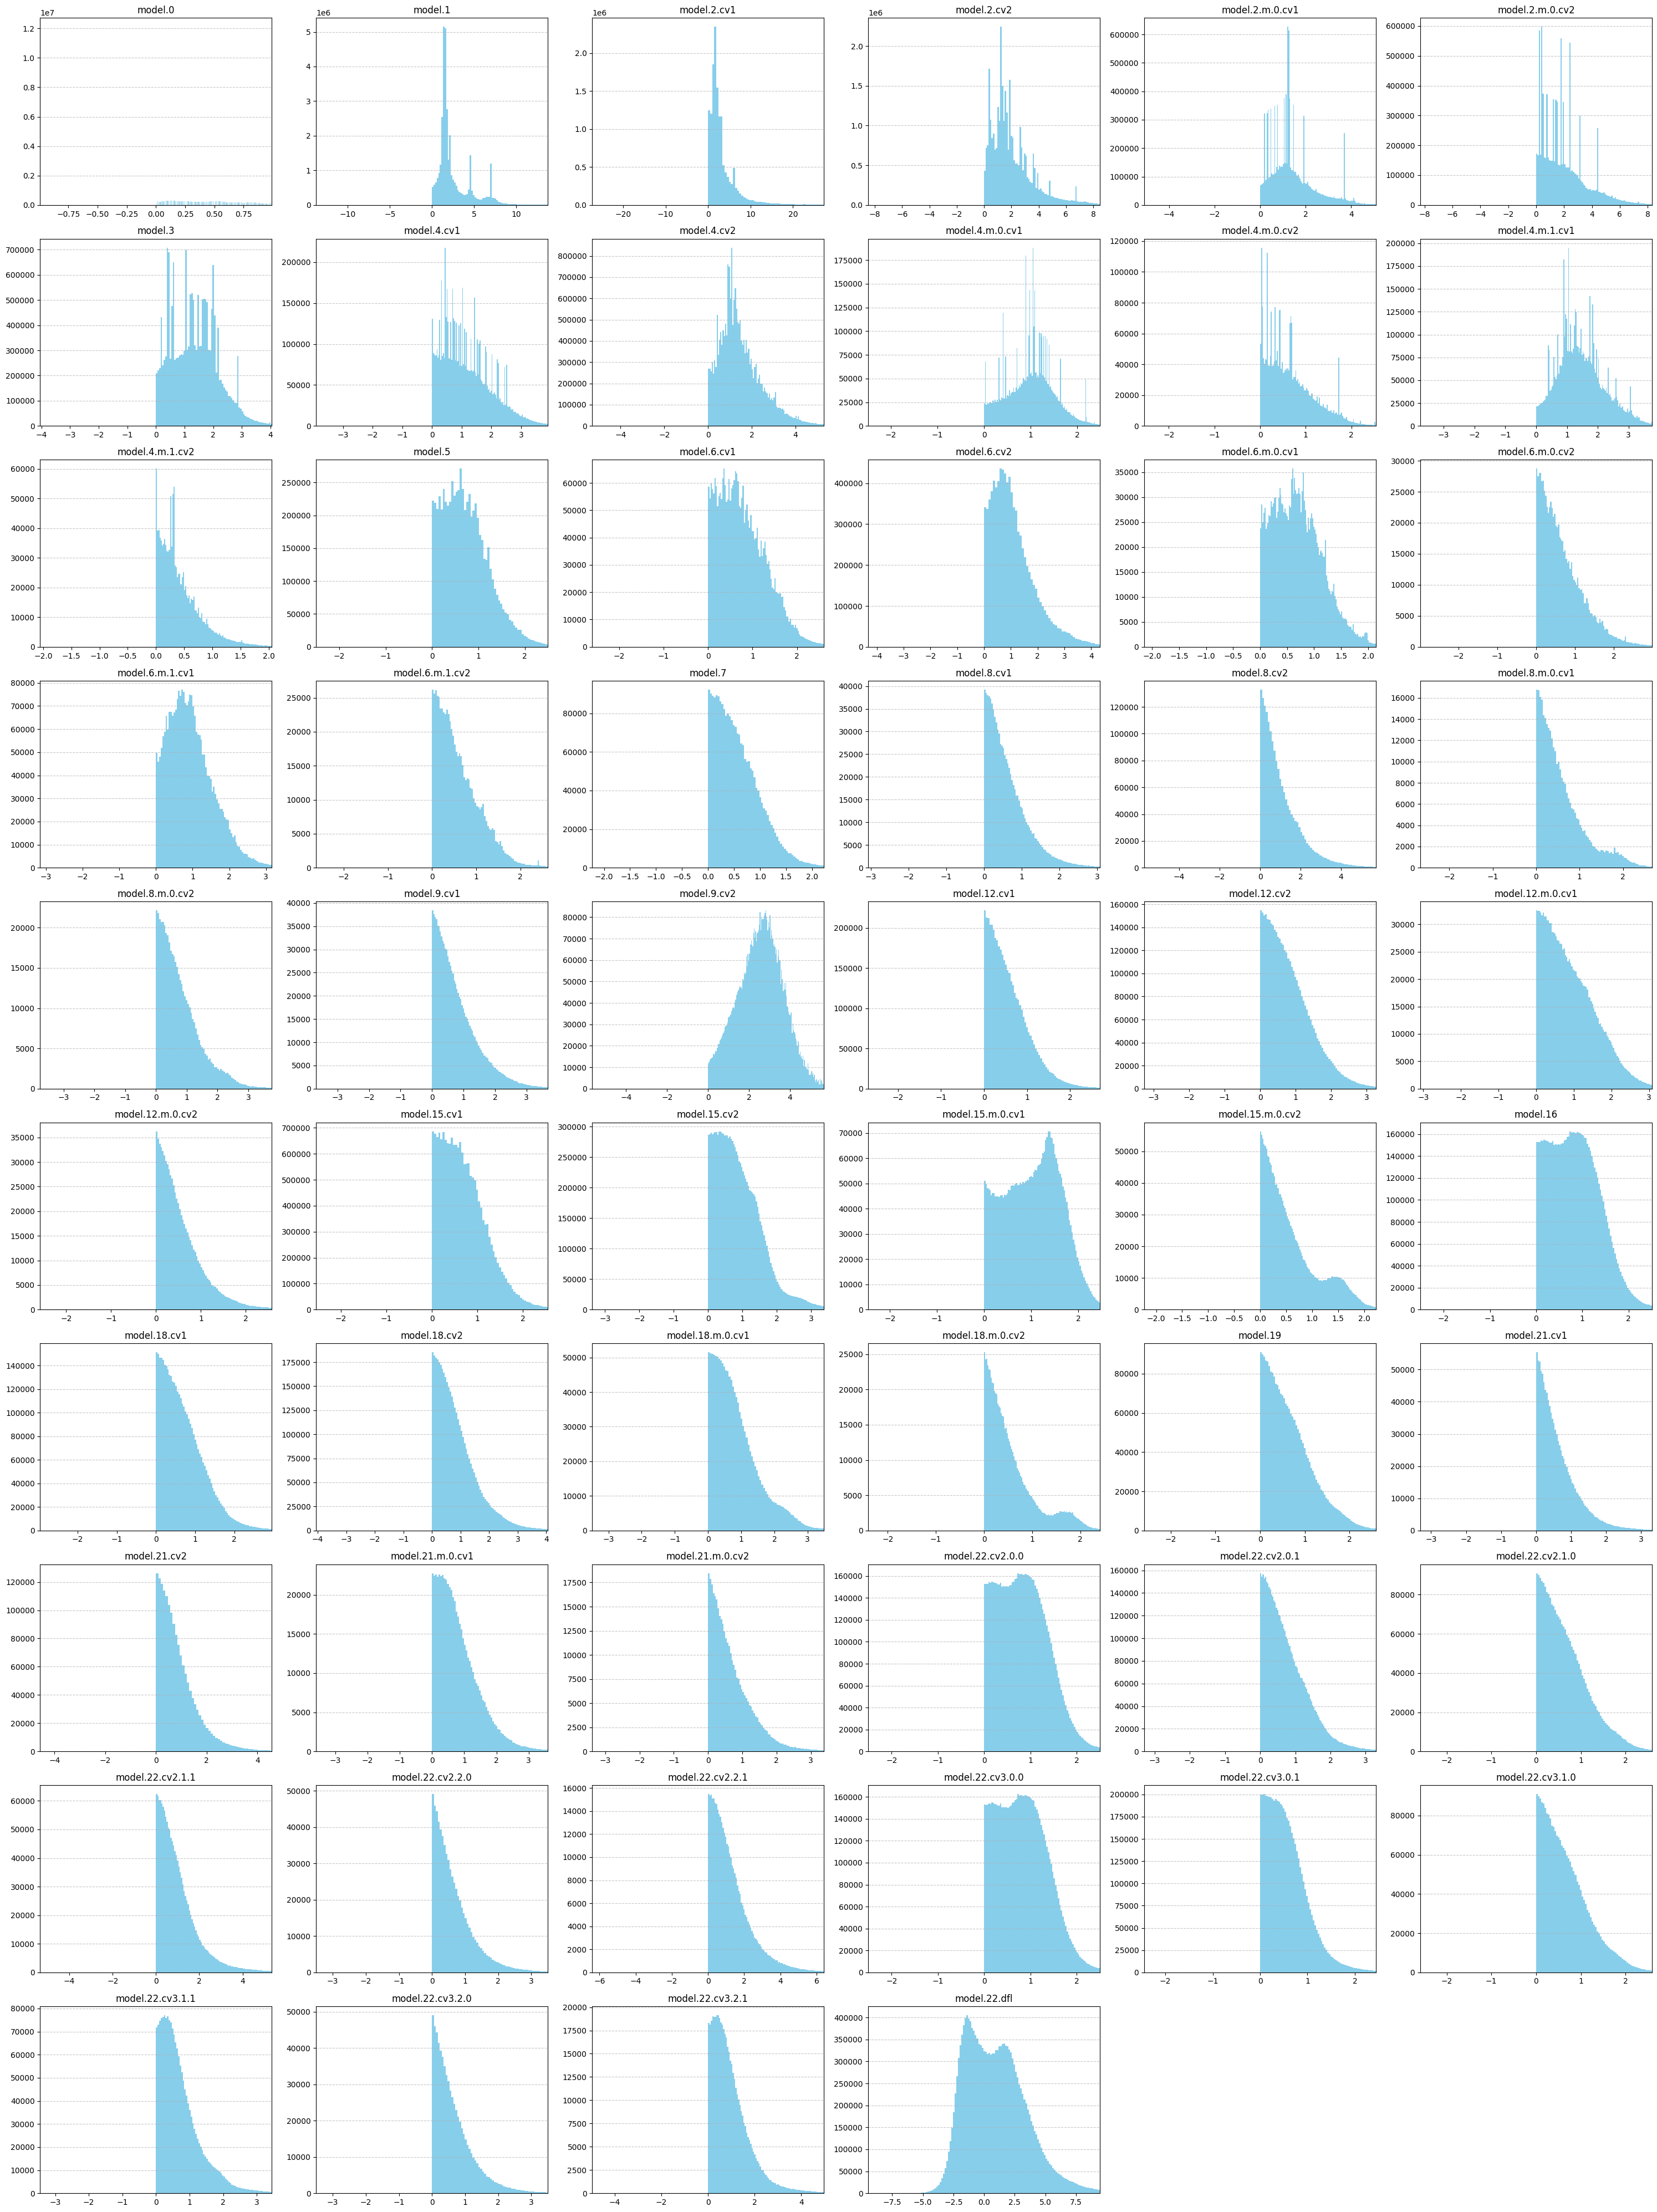

In [8]:
# load QAT model with quantization config
# with open('./config/qcfg_0928.yaml') as f:
#     loaded_cfg = yaml.safe_load(f)

# Qmodel = load_model('checkpoints/qat_09272248.pt', device, model_type="qat", model_qcfg=loaded_cfg)

with open('./config/qcfg_0327.yaml') as f:
    loaded_cfg = yaml.safe_load(f)

Qmodel = load_model('checkpoints/qat_09270730.pt', device, model_type="qat", model_qcfg=loaded_cfg)


asc = ActivationStatsCollector(Qmodel, (QConv, DFL))

run_batch = 2
for _ in range(run_batch): # run multiple iterations to collect activation statistics
    with torch.no_grad():
        images, annotations = next(iter(train_loader))
        inputs, batch = preprocess_dataset(images, annotations, coco_id2label, device) # preprocess dataset
        outputs = Qmodel(inputs, inference=True)
activation_stats = asc.get_stats()

act_stats = {}
for layer_name, acts in activation_stats.items():
    acts = torch.cat(acts, dim=0)  # concatenate all batches
    try:
        temp = acts.permute(1, 0, 2, 3).contiguous()
        zero_mask = acts != 0 
        act_stats[layer_name] = acts[zero_mask] if zero_mask.sum() > 0 else torch.tensor(0.0)
    except:
        act_stats[layer_name] = acts

visualize_multiple_tensors(act_stats, bins=256, n_cols=6) # zero values are excluded

# Act2

In [73]:
s=7
[([f, -(2**s)/ (2 ** f), (2**s-1)/ (2 ** f)]) for f in range(-4, 8)]

[[-4, -2048.0, 2032.0],
 [-3, -1024.0, 1016.0],
 [-2, -512.0, 508.0],
 [-1, -256.0, 254.0],
 [0, -128.0, 127.0],
 [1, -64.0, 63.5],
 [2, -32.0, 31.75],
 [3, -16.0, 15.875],
 [4, -8.0, 7.9375],
 [5, -4.0, 3.96875],
 [6, -2.0, 1.984375],
 [7, -1.0, 0.9921875]]

In [74]:
s=8
[([f, 0, (2**s-1)/ (2 ** f)]) for f in range(-4, 9)]

[[-4, 0, 4080.0],
 [-3, 0, 2040.0],
 [-2, 0, 1020.0],
 [-1, 0, 510.0],
 [0, 0, 255.0],
 [1, 0, 127.5],
 [2, 0, 63.75],
 [3, 0, 31.875],
 [4, 0, 15.9375],
 [5, 0, 7.96875],
 [6, 0, 3.984375],
 [7, 0, 1.9921875],
 [8, 0, 0.99609375]]

In [ ]:
# load QAT model with quantization config


# with open('./config/qcfg_0928.yaml') as f:
#     loaded_cfg = yaml.safe_load(f)
# Qmodel = load_model('checkpoints/qat_09272248.pt', device, model_type="qat", model_qcfg=loaded_cfg)

with open('./config/qcfg_0327.yaml') as f:
    loaded_cfg = yaml.safe_load(f)
Qmodel = load_model('checkpoints/qat_09270730.pt', device, model_type="qat", model_qcfg=loaded_cfg)

# with open('./config/quantization_config.yaml') as f:
    # loaded_cfg = yaml.safe_load(f)
# Qmodel = load_model('checkpoints/qat_091501.pth', device, model_type="qat", model_qcfg=loaded_cfg)

# with open('./config/quantization_config.yaml') as f:
#     loaded_cfg = yaml.safe_load(f)
# Qmodel = load_QAT_model('checkpoints/relu_091214.pth', device, model_qcfg=loaded_cfg)

asc = ActivationStatsCollector(Qmodel, (QConv2d, DFL))

run_batch = 2
for _ in range(run_batch): # run multiple iterations to collect activation statistics
    with torch.no_grad():
        images, annotations = next(iter(train_loader))
        inputs, batch = preprocess_dataset(images, annotations, coco_id2label, device) # preprocess dataset
        outputs = Qmodel(inputs, inference=True)
activation_stats = asc.get_stats()

act_stats = {}
for layer_name, acts in activation_stats.items():
    acts = torch.cat(acts, dim=0)  # concatenate all batches
    try:
        temp = acts.permute(1, 0, 2, 3).contiguous()
        zero_mask = acts != 0 
        act_stats[layer_name] = acts[zero_mask] if zero_mask.sum() > 0 else torch.tensor(0.0)
    except:
        act_stats[layer_name] = acts

import math
def get_frac_bits(num_ubits, x) -> int:
    exp = math.floor(math.log2((2**num_ubits - 1)/x)) 
    return exp 

af_list = []
names = list(act_stats.keys())
for i, name in enumerate(names):
    tensor = act_stats[name].flatten()
    max_val = tensor.kthvalue(int(tensor.numel() * 0.999)).values.item()
    f = get_frac_bits(8, max_val)
    af_list.append(f)
    
    print(f"{name:<25} | max={max_val:<7.2f} | frac_bits={f}")

Start matching keys...

Matching keys done.

model.0.conv              | max=0.99    | frac_bits=8
model.1.conv              | max=21.31   | frac_bits=3
model.2.cv1.conv          | max=44.42   | frac_bits=2
model.2.cv2.conv          | max=11.09   | frac_bits=4
model.2.m.0.cv1.conv      | max=6.75    | frac_bits=5
model.2.m.0.cv2.conv      | max=11.27   | frac_bits=4
model.3.conv              | max=5.31    | frac_bits=5
model.4.cv1.conv          | max=4.62    | frac_bits=5
model.4.cv2.conv          | max=6.43    | frac_bits=5
model.4.m.0.cv1.conv      | max=2.93    | frac_bits=6
model.4.m.0.cv2.conv      | max=3.03    | frac_bits=6
model.4.m.1.cv1.conv      | max=4.34    | frac_bits=5
model.4.m.1.cv2.conv      | max=2.66    | frac_bits=6
model.5.conv              | max=3.18    | frac_bits=6
model.6.cv1.conv          | max=3.31    | frac_bits=6
model.6.cv2.conv          | max=5.39    | frac_bits=5
model.6.m.0.cv1.conv      | max=2.68    | frac_bits=6
model.6.m.0.cv2.conv      | max=3.80 

In [ ]:
with open('./config/quantization_config.yaml') as f:
    loaded_cfg = yaml.safe_load(f)
Qmodel = load_QAT_model('checkpoints/relu_091214.pth', device, model_qcfg=loaded_cfg)
with open('./config/qcfg_0327.yaml') as f:
    loaded_cfg = yaml.safe_load(f)
Qmodel2 = load_model('checkpoints/qat_09270730.pt', device, model_type="qat", model_qcfg=loaded_cfg)


w_stats = Qmodel.state_dict()
w_stats2 = Qmodel2.state_dict()

names = list(w_stats.keys())

wf_list = []

for i, name in enumerate(names):
    if 'weight' not in name:
        continue
    tensor = w_stats[name].flatten()
    max_val = tensor.kthvalue(int(tensor.numel() * 0.999)).values.item()
    f = get_frac_bits(7, max_val)
    wf_list.append(f)

    tensor = w_stats2[name].flatten()
    max_val2 = tensor.kthvalue(int(tensor.numel() * 0.999)).values.item()
    f2 = get_frac_bits(7, max_val2)
    print(f"{name:<35} | max={max_val:<7.2f}, {max_val2:<7.2f} | frac_bits={f}, frac_bits2={f2}")

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.
Loaded .pth state_dict
Start matching keys...

Matching keys done.

Start matching keys...

Matching keys done.

model.0.conv.weight                 | max=12.17  , 12.16   | frac_bits=3, frac_bits2=3
model.1.conv.weight                 | max=1.96   , 1.97    | frac_bits=6, frac_bits2=6
model.2.cv1.conv.weight             | max=0.34   , 0.34    | frac_bits=8, frac_bits2=8
model.2.cv2.conv.weight             | max=0.65   , 0.65    | frac_bits=7, frac_bits2=7
model.2.m.0.cv1.conv.weight         | max=2.05   , 2.05    | frac_bits=5, frac_bits2=5
model.2.m.0.cv2.conv.weight         | max=0.60   , 0.61    | frac_bits=7, frac_bits2=7
model.3.conv.weight                 | max=0.27   , 0.27    | frac_bits=8, frac_bits2=8
model.4.cv1.conv.weight             | max=1.17   , 1.17    | frac_bits=6, frac_bits2=6
model.4.cv2.conv.weight             | max=0.4

### Q Config Gen

In [ ]:
def bottleneck_qcfg_gen(cfg):
    return {
        "cv1": cfg.pop(0),
        "cv2": cfg.pop(0),
    }

def c2f_qcfg_gen(cfg, n):
    ret = {
        "cv1": cfg.pop(0),
        "cv2": cfg.pop(0),
    }
    for i in range(n):
        ret[f"m.{i}"] = bottleneck_qcfg_gen(cfg)
    return ret

def sppf_qcfg_gen(cfg):
    return {
        "cv1": cfg.pop(0),
        "cv2": cfg.pop(0),
    }

def detect_qcfg_gen(cfg):
    return {
        "cv2.0": cfg.pop(0),
        "cv2.1": cfg.pop(0),
        "cv2.2": cfg.pop(0),

        "cv3.0": cfg.pop(0),
        "cv3.1": cfg.pop(0),
        "cv3.2": cfg.pop(0),
    }

a = af_list # activation fraction bits, sequential
w = wf_list # weight fraction bits, sequential
num_bits = 8

# note: config format: [num_bits, w_fraction_bits, a_fraction_bits]
quantization_config = {
    "layer_0": [num_bits, w.pop(0), a.pop(0)],
    "layer_1": [num_bits, w.pop(0), a.pop(0)],
    "layer_2": c2f_qcfg_gen([
        [num_bits, w.pop(0), a.pop(0)], # cv1
        [num_bits, w.pop(0), a.pop(0)], # cv2
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv1
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv2
    ], 1),
    "layer_3": [num_bits, w.pop(0), a.pop(0)],
    "layer_4": c2f_qcfg_gen([
        [num_bits, w.pop(0), a.pop(0)], # cv1
        [num_bits, w.pop(0), a.pop(0)], # cv2
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv1
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv2
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 1.cv1
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 1.cv2
    ], 2),
    "layer_5": [num_bits, w.pop(0), a.pop(0)],
    "layer_6": c2f_qcfg_gen([
        [num_bits, w.pop(0), a.pop(0)], # cv1
        [num_bits, w.pop(0), a.pop(0)], # cv2
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv1
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv2
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 1.cv1
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 1.cv2
    ], 2),
    "layer_7": [num_bits, w.pop(0), a.pop(0)],
    "layer_8": c2f_qcfg_gen([
        [num_bits, w.pop(0), a.pop(0)], # cv1
        [num_bits, w.pop(0), a.pop(0)], # cv2
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv1
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv2
    ], 1),
    "layer_9": sppf_qcfg_gen([
        [num_bits, w.pop(0), a.pop(0)], # cv1
        [num_bits, w.pop(0), a.pop(0)], # cv2
    ]),
    "layer_12": c2f_qcfg_gen([
        [num_bits, w.pop(0), a.pop(0)], # cv1
        [num_bits, w.pop(0), a.pop(0)], # cv2
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv1
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv2
    ], 1),
    "layer_15": c2f_qcfg_gen([
        [num_bits, w.pop(0), a.pop(0)], # cv1
        [num_bits, w.pop(0), a.pop(0)], # cv2
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv1
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv2
    ], 1),
    "layer_16": [num_bits, w.pop(0), a.pop(0)],
    "layer_18": c2f_qcfg_gen([
        [num_bits, w.pop(0), a.pop(0)], # cv1
        [num_bits, w.pop(0), a.pop(0)], # cv2
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv1
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv2
    ], 1),
    "layer_19": [num_bits, w.pop(0), a.pop(0)],
    "layer_21": c2f_qcfg_gen([
        [num_bits, w.pop(0), a.pop(0)], # cv1
        [num_bits, w.pop(0), a.pop(0)], # cv2
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv1
        [num_bits, w.pop(0), a.pop(0)], # bottleneck 0.cv2
    ], 1),
    "layer_22": detect_qcfg_gen([
        [num_bits, w.pop(0), a.pop(0)], # cv2.0
        [num_bits, w.pop(0), a.pop(0)], # cv2.1
        [num_bits, w.pop(0), a.pop(0)], # cv2.2
        [num_bits, w.pop(0), a.pop(0)], # cv3.0
        [num_bits, w.pop(0), a.pop(0)], # cv3.1
        [num_bits, w.pop(0), a.pop(0)], # cv3.2
    ]),
}

import yaml


# YAML save 
class MyDumper(yaml.SafeDumper):
    pass

def represent_list_flow(dumper, data):
    return dumper.represent_sequence('tag:yaml.org,2002:seq', data, flow_style=True)

MyDumper.add_representer(list, represent_list_flow)

from datetime import datetime

# Model Save
now = datetime.now()
formatted = now.strftime("%m%d%H%M")

name = 'qcfg_1'
# save
with open(f'./config/qcfg_{formatted}.yaml', 'w') as f:
    yaml.dump(quantization_config, f, Dumper=MyDumper, sort_keys=False)

# load
with open(f'./config/qcfg_{formatted}.yaml') as f:
    loaded_cfg = yaml.safe_load(f)

# check
print(loaded_cfg)



# Outlier Analysis

# Demo

In [6]:
demo(train_loader, Nmodel, device, coco_id2label, label2coco_category, iou_threshold=0.3)

In [15]:
demo(train_loader, Qmodel, device, coco_id2label, label2coco_category, iou_threshold=0.7)

# Quantization Config Generator

In [ ]:
def bottleneck_qcfg_gen(cfg):
    return {
        "cv1": cfg.pop(0),
        "cv2": cfg.pop(0),
    }

def c2f_qcfg_gen(cfg, n):
    ret = {
        "cv1": cfg.pop(0),
        "cv2": cfg.pop(0),
    }
    for i in range(n):
        ret[f"m.{i}"] = bottleneck_qcfg_gen(cfg)
    return ret

def sppf_qcfg_gen(cfg):
    return {
        "cv1": cfg.pop(0),
        "cv2": cfg.pop(0),
    }

def detect_qcfg_gen(cfg):
    return {
        "cv2.0": cfg.pop(0),
        "cv2.1": cfg.pop(0),
        "cv2.2": cfg.pop(0),

        "cv3.0": cfg.pop(0),
        "cv3.1": cfg.pop(0),
        "cv3.2": cfg.pop(0),
    }

# note: config format: [num_bits, w_fraction_bits, a_fraction_bits]
quantization_config = {
    "layer_0": [8,3,7],
    "layer_1": [8,6,4],
    "layer_2": c2f_qcfg_gen([[8,6,4], # cv1
                             [8,6,4], # cv2
                             [8,6,4], # bottleneck 0.cv1
                             [8,6,4], # bottleneck 0.cv2
                             ], 1),
    "layer_3": [8,6,4],
    "layer_4": c2f_qcfg_gen([[8,6,4], # cv1
                             [8,6,4], # cv2
                             [8,6,4], # bottleneck 0.cv1
                             [8,6,4], # bottleneck 0.cv2
                             [8,6,4], # bottleneck 1.cv1
                             [8,6,4], # bottleneck 1.cv2
                             ], 2),
    "layer_5": [8,6,4],
    "layer_6": c2f_qcfg_gen([[8,6,4], # cv1
                             [8,6,4], # cv2
                             [8,6,4], # bottleneck 0.cv1
                             [8,6,4], # bottleneck 0.cv2
                             [8,6,4], # bottleneck 1.cv1
                             [8,6,4], # bottleneck 1.cv2
                             ], 2),
    "layer_7": [8,6,4],
    "layer_8": c2f_qcfg_gen([[8,6,4], # cv1
                             [8,6,4], # cv2
                             [8,6,4], # bottleneck 0.cv1
                             [8,6,4], # bottleneck 0.cv2
                             ], 1),
    "layer_9": sppf_qcfg_gen([[8,6,4], # cv1
                              [8,6,4], # cv2
                              ]),
    "layer_12": c2f_qcfg_gen([[8,6,4], # cv1
                              [8,6,4], # cv2
                              [8,6,4], # bottleneck 0.cv1
                              [8,6,4], # bottleneck 0.cv2
                              ], 1),
    "layer_15": c2f_qcfg_gen([[8,6,4], # cv1
                              [8,6,4], # cv2
                              [8,6,4], # bottleneck 0.cv1
                              [8,6,4], # bottleneck 0.cv2
                              ], 1),
    "layer_16": [8,6,4],
    "layer_18": c2f_qcfg_gen([[8,6,4], # cv1
                              [8,6,4], # cv2
                              [8,6,4], # bottleneck 0.cv1
                              [8,6,4], # bottleneck 0.cv2
                              ], 1),
    "layer_19": [8,6,4],
    "layer_21": c2f_qcfg_gen([[8,6,4], # cv1
                              [8,6,4], # cv2
                              [8,6,4], # bottleneck 0.cv1
                              [8,6,4], # bottleneck 0.cv2
                              ], 1),

    "layer_22": detect_qcfg_gen([[8,6,4], # cv2.0
                                 [8,6,4], # cv2.1
                                 [8,7,4], # cv2.2
                                 [8,6,4], # cv3.0
                                 [8,6,4], # cv3.1
                                 [8,7,3], # cv3.2
                                 ]),
}

import yaml


# YAML save 
class MyDumper(yaml.SafeDumper):
    pass

def represent_list_flow(dumper, data):
    return dumper.represent_sequence('tag:yaml.org,2002:seq', data, flow_style=True)

MyDumper.add_representer(list, represent_list_flow)

# save
with open('./config/quantization_config.yaml', 'w') as f:
    yaml.dump(quantization_config, f, Dumper=MyDumper, sort_keys=False)

# load
with open('./config/quantization_config.yaml') as f:
    loaded_cfg = yaml.safe_load(f)

# check
print(loaded_cfg)

